# 02_baseline_xgb – prototyping
Notebook to prototype preprocessing + baseline models (LogReg, RandomForest, XGBoost) before moving code into scripts.

## Environment
Install deps once before running the notebook: `pip install -r requirements.txt`.

In [42]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap

%matplotlib inline
sns.set_theme(style='whitegrid')
data_path = Path('/home/jbarone/dev/capstone_1/data/raw/credit_risk_dataset.csv')
df = pd.read_csv(data_path)
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [43]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


((32581, 12), None)

In [44]:
# Target distribution (loan_status: 1=default, 0=paid)
target_rate = df['loan_status'].mean()
print('Default rate ~', round(target_rate*100, 2), '%')
df['loan_status'].value_counts(normalize=True)

Default rate ~ 21.82 %


loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

## Feature lists
We split columns into numeric vs categorical. Target = `loan_status`.

In [45]:
target = 'loan_status'
num_features = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]
cat_features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]
X = df[num_features + cat_features]
y = df[target]

## Quick target imbalance and feature peeks
Optional quick plots to visualize imbalance and key categorical signals.

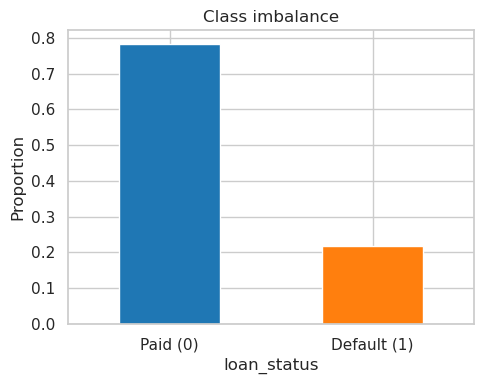

In [46]:
fig, ax = plt.subplots(figsize=(5,4))
df['loan_status'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax, color=['tab:blue','tab:orange'])
ax.set_xticklabels(['Paid (0)','Default (1)'], rotation=0)
ax.set_ylabel('Proportion')
ax.set_title('Class imbalance')
plt.tight_layout()

/tmp/ipykernel_877042/1022193288.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grade_default, x='loan_grade', y='default_rate', palette='magma')


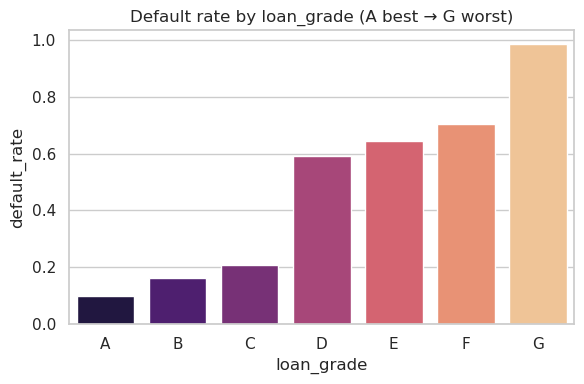

In [47]:
grade_default = df.groupby('loan_grade')['loan_status'].mean().reset_index().rename(columns={'loan_status':'default_rate'})
plt.figure(figsize=(6,4))
sns.barplot(data=grade_default, x='loan_grade', y='default_rate', palette='magma')
plt.title('Default rate by loan_grade (A best → G worst)')
plt.tight_layout()

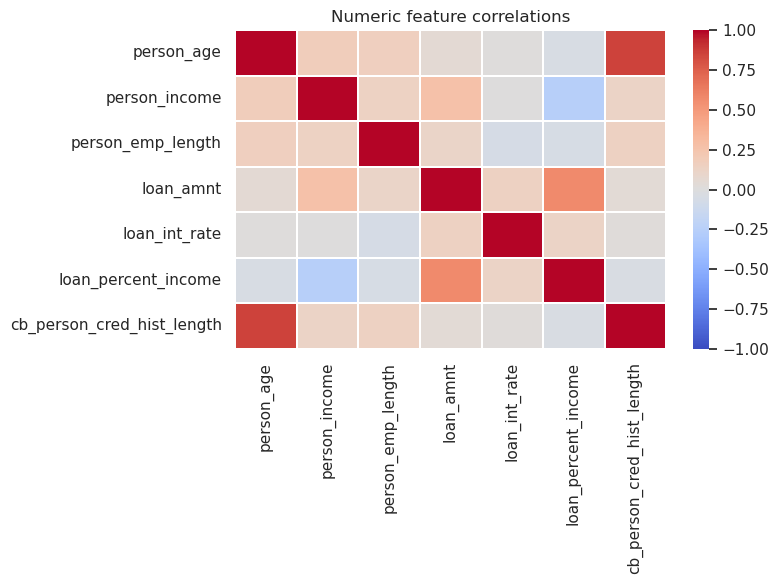

In [48]:
# Correlation heatmap for numeric features
corr = df[num_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.3)
plt.title('Numeric feature correlations')
plt.tight_layout()

## Simple outlier clipping (before preprocessing)
Cap extreme ages and employment lengths so they don’t dominate scaling.
Tune thresholds here; we’ll reuse the logic in scripts later.

In [49]:
X_clip = X.copy()
X_clip['person_age'].clip(upper=90, inplace=True)
X_clip['person_emp_length'].clip(upper=60, inplace=True)  # ✅ _ au lieu de camelCase
X_clip['loan_int_rate'].clip(upper=40, inplace=True)     # intrate → loan_int_rate
X_clip['loan_percent_income'].clip(upper=1.5, inplace=True)
print(X_clip[['person_age','person_emp_length','loan_int_rate','loan_percent_income']].describe())


         person_age  person_emp_length  loan_int_rate  loan_percent_income
count  32581.000000       31686.000000   29465.000000         32581.000000
mean      27.727479           4.785710      11.011695             0.170203
std        6.251034           4.058539       3.240459             0.106782
min       20.000000           0.000000       5.420000             0.000000
25%       23.000000           2.000000       7.900000             0.090000
50%       26.000000           4.000000      10.990000             0.150000
75%       30.000000           7.000000      13.470000             0.230000
max       90.000000          60.000000      23.220000             0.830000


/tmp/ipykernel_877042/195396659.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_clip['person_age'].clip(upper=90, inplace=True)
/tmp/ipykernel_877042/195396659.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

## Preprocessor (ColumnTransformer)
- Numeric: median imputer + standard scaler
- Categorical: most frequent imputer + one-hot (ignore unknowns)

In [50]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

## Train/validation split
Stratify to preserve class balance.

In [51]:
X_train, X_val, y_train, y_val = train_test_split(
    X_clip, y, test_size=0.2, stratify=y, random_state=42
)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(3.5838902567710167)

## Helper to train + evaluate
Returns ROC-AUC on validation.

In [52]:
def fit_eval(model, name, results):
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)
    results.append({'model': name, 'val_auc': auc})
    print(f'{name} AUC: {auc:.4f}')
    return model

results = []

## Logistic Regression (class_weight balanced)
Baseline linear model with weighting to address imbalance.

In [53]:
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])
log_reg = fit_eval(log_reg, 'LogisticRegression', results)

LogisticRegression AUC: 0.8712


## RandomForest (class_weight balanced)
Tree ensemble baseline.

In [54]:
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])
rf = fit_eval(rf, 'RandomForest', results)

RandomForest AUC: 0.9307


## XGBoost (scale_pos_weight)
Gradient boosted trees; use scale_pos_weight to handle imbalance.

In [55]:
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    ))
])
xgb = fit_eval(xgb, 'XGBoost', results)

XGBoost AUC: 0.9495


## (Optional) XGBoost + SMOTE
Another way to handle imbalance is oversampling. This pipeline applies preprocessing → SMOTE → XGB.

In [56]:
xgb_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        n_estimators=250,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    ))
])
xgb_smote = fit_eval(xgb_smote, 'XGBoost+SMOTE', results)

XGBoost+SMOTE AUC: 0.9385


## Compare AUCs
Pick the best model (likely XGBoost) to carry forward into scripts.

In [57]:
results_df = pd.DataFrame(results).sort_values('val_auc', ascending=False)
results_df

,model,val_auc
2,XGBoost,0.949466
3,XGBoost+SMOTE,0.938520
1,RandomForest,0.930746
0,LogisticRegression,0.871180


## Quick SHAP on XGBoost (optional)
Interpret feature impact on a sample; this can be slow on full data.

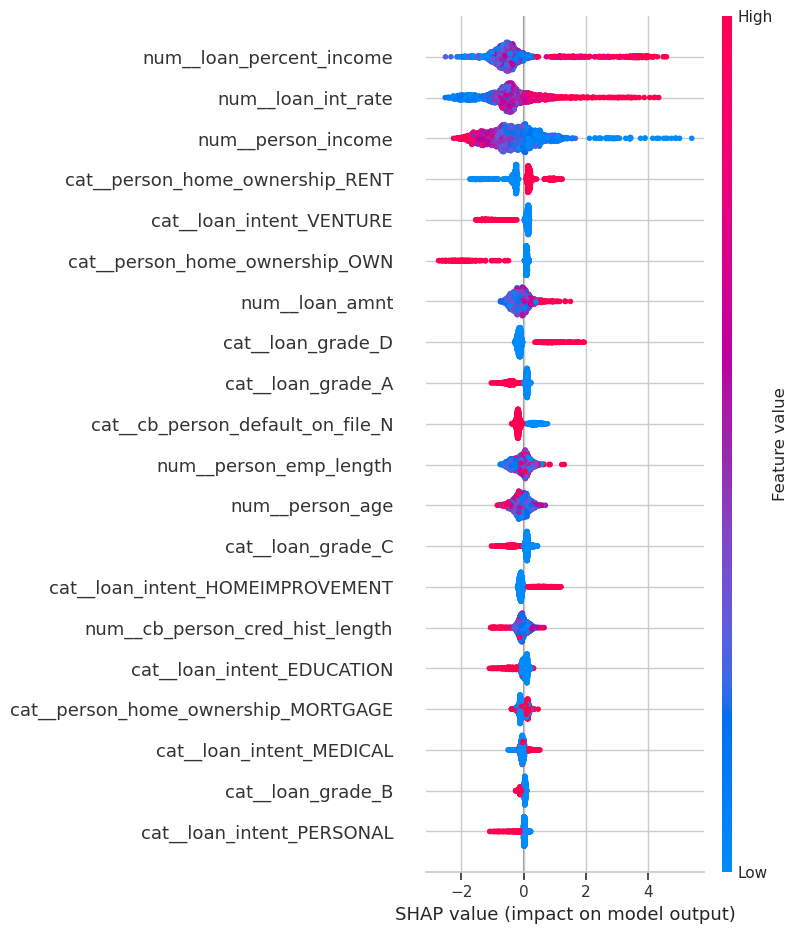

In [59]:
# Take a small sample to keep SHAP fast
sample_idx = np.random.RandomState(42).choice(len(X_train), size=min(2000, len(X_train)), replace=False)
X_sample = X_train.iloc[sample_idx]

# Fit a fresh XGB on the sample for SHAP speed
xgb_small = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    ))
])
xgb_small.fit(X_sample, y_train.iloc[sample_idx])

# Transform sample for SHAP and make it dense if needed
X_processed = xgb_small.named_steps['preprocess'].transform(X_sample)
feature_names = xgb_small.named_steps['preprocess'].get_feature_names_out()
if hasattr(X_processed, 'toarray'):
    X_dense = X_processed.toarray()
else:
    X_dense = X_processed

# TreeExplainer works well with XGBClassifier
explainer = shap.TreeExplainer(xgb_small.named_steps['model'])
shap_values = explainer(X_dense)
shap.summary_plot(shap_values, features=X_dense, feature_names=feature_names, show=False)
plt.show()


### SHAP takeaway
SHAP explains the model by showing how each feature pushes the prediction up or down for each sample.
- Bars farther from zero mean a feature has more impact.
- Colors show feature values (blue = low, red = high).
What to expect here (typical run):
- High `loan_int_rate` and high `loan_percent_income` push towards default (red on the positive side).
- Lower `loan_grade` (like F/G) and `cb_person_default_on_file = Y` also push towards default.
- Higher income/grade A-B tend to push towards paid (blue on the negative side).
Implication: focus on interest rate, payment-to-income ratio, grade, and prior defaults as key levers for underwriting or pricing.


## Recap
- Target is imbalanced (~20% defaults), so class weights or SMOTE stay in the plan.
- Categorical signals: lower loan_grade (C/D/F/G) and prior default flag = Y push risk up.
- Numeric signals: higher interest rate and loan_percent_income show up as top risk drivers.
- Outliers: we clip age (~90), employment length (~60), interest rate (~40), payment ratio (~1.5) to avoid weird extremes.
- Preprocessing locked: median/mode impute + scaler for nums, OHE for cats, ignore unknowns.
- Models tested: Logistic (weighted), RandomForest (weighted), XGBoost (scale_pos_weight + optional SMOTE).
- Next for scripts: keep the same feature lists, clipping logic, and the best model (likely XGB) for train.py/predict.py.
